# Charger, organiser et explorer un jeu de données avec iPython et sqLite

Les données utilisées sont les statistiques de mortalité aux Etats-Unis en 2014. Ces données sont disponibles sur le site du Center For Disease Control (CDC) ou en format csv et sqLite sur le site Kaggle (https://www.kaggle.com/cdc/mortality)

Le début de ce notebook vise à comparer les fonctions SQL et pandas pour effectuer les mêmes opérations

In [3]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
import os
from sqlite3 import dbapi2 as sq3
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")

In [ ]:
# -------------------------------------------------------------------------
# A effectuer seulement la première fois du lancement du notebook : 
# Charge le CSV dans le notebook et l'envois dans la BDD
# Long...
# --------------------------------------------------------------------------

# Chargement des données dans le notebook
dr = pd.read_csv('Dataset/DeathRecords.csv')

# Premier regard sur les données
dr.info()

# Créer le schema de la table
schema="""
DROP TABLE IF EXISTS "causesofdeath";
CREATE TABLE "causesofdeath" (
    "id" INTEGER NOT NULL,
    "ResidentStatus" INTEGER,
    "Education1989Revision" INTEGER,
    "Education2003Revision" INTEGER,
    "EducationReportingFlag" INTEGER,
    "MonthOfDeath" INTEGER,
    "Sex" VARCHAR(1),
    "AgeType" INTEGER,
    "Age" INTEGER,
    "AgeSubstitutionFlag" INTEGER,
    "AgeRecode52" INTEGER,
    "AgeRecode27" INTEGER,
    "AgeRecode12" INTEGER,
    "InfantAgeRecode22" INTEGER,    
    "PlaceOfDeathAndDecedentsStatus" INTEGER,    
    "MaritalStatus" VARCHAR(1),    
    "DayOfWeekOfDeath" INTEGER,
    "CurrentDataYear" INTEGER,
    "InjuryAtWork" VARCHAR,
    "MannerOfDeath" INTEGER,
    "MethodOfDisposition" VARCHAR(1),
    "Autopsy" VARCHAR(1),
    "ActivityCode" INTEGER,
    "PlaceOfInjury" INTEGER,
    "Icd10Code" VARCHAR(4),
    "CauseRecode358" INTEGER,
    "CauseRecode113" INTEGER,
    "InfantCauseRecode130" INTEGER,
    "CauseRecode39" INTEGER,
    "NumberOfEntityAxisConditions" INTEGER,
    "NumberOfRecordAxisConditions" INTEGER,
    "Race" INTEGER,
    "BridgedRaceFlag" INTEGER,
    "RaceImputationFlag" INTEGER,
    "RaceRecode3" INTEGER,
    "RaceRecode5" INTEGER,
    "HispanicOrigin" INTEGER,
    "HispanicOriginRaceRecode" INTEGER
);
"""

# Se connecter a la base de données
PATHSTART="Dataset/"
def get_db(dbfile):
    sqlite_db = sq3.connect(os.path.join(PATHSTART, dbfile))
    return sqlite_db

db = get_db("CDC.db")

# Ajouter les données
dr.to_sql("causesofdeath", db, if_exists="append", index=False)

In [4]:
# Se connecter a la base de données
PATHSTART="Dataset/"
def get_db(dbfile):
    sqlite_db = sq3.connect(os.path.join(PATHSTART, dbfile))
    return sqlite_db

db = get_db("CDC.db")

In [6]:
# Fonction pour faciliter le requetage simple
def sql_query(str):
    return db.cursor().execute(str).fetchall()

On récupère un échantillon des données et on créé un df plus petit. 
Ce dataframe sera utilisé pour permettre de comparer les requetes SQL avec les fonctions de pandas

In [60]:
# On recupère les infos de la Bases
table_info = sql_query("PRAGMA table_info(causesofdeath);")
column_names = [x[1] for x in table_info]

# On selectionne au hasard les lignes de la base de donénes et on les stocke dans un dataframe
sel_random = 'SELECT * FROM causesofdeath ORDER BY Random() LIMIT 100000'
#sel_random = "SELECT * FROM causesofdeath WHERE id = ?"
df = pd.DataFrame(db.cursor().execute(sel_random).fetchall(),columns = column_names)
df.head()

,id,ResidentStatus,Education1989Revision,Education2003Revision,EducationReportingFlag,MonthOfDeath,Sex,AgeType,Age,AgeSubstitutionFlag,AgeRecode52,AgeRecode27,AgeRecode12,InfantAgeRecode22,PlaceOfDeathAndDecedentsStatus,MaritalStatus,DayOfWeekOfDeath,CurrentDataYear,InjuryAtWork,MannerOfDeath,MethodOfDisposition,Autopsy,ActivityCode,PlaceOfInjury,Icd10Code,CauseRecode358,CauseRecode113,InfantCauseRecode130,CauseRecode39,NumberOfEntityAxisConditions,NumberOfRecordAxisConditions,Race,BridgedRaceFlag,RaceImputationFlag,RaceRecode3,RaceRecode5,HispanicOrigin,HispanicOriginRaceRecode
0,1169399,1,0,5,1,10,F,1,91,0,44,24,11,0,4,W,7,2014,U,7,R,N,99,99,I350,225,68,0,22,2,2,1,0,0,1,1,100,6
1,1734078,1,0,3,1,1,M,1,85,0,43,23,11,0,1,W,7,2014,U,7,C,N,99,99,J961,278,89,0,37,3,3,2,0,0,3,2,100,7
2,735908,2,0,6,1,10,M,1,70,0,40,20,9,0,1,D,2,2014,U,7,C,N,99,99,I629,236,70,0,24,2,2,1,0,0,1,1,100,6
3,1144762,1,12,0,0,9,M,1,82,0,42,22,10,0,6,W,2,2014,U,7,U,N,99,99,I64,238,70,0,24,2,2,2,0,0,3,2,100,7
4,2030325,1,0,3,1,11,M,1,64,0,38,18,8,0,2,M,1,2014,U,7,R,N,99,99,I713,242,73,0,26,1,1,1,0,0,1,1,100,6


On vérifie que toutes les données sont dans la BDD

In [171]:
print('nombre de ligne dans la bdd :',sql_query("SELECT COUNT(Id) FROM causesofdeath"))
print('nombre de colonnes dans la bdd', len(sql_query("PRAGMA table_info(causesofdeath);")))
print('nombre de lignes et de colonnes dans le sample: ',df.shape)


nombre de ligne dans la bdd : [(2631171,)]
nombre de colonnes dans la bdd 39
nombre de lignes et de colonnes dans le sample:  (100000, 38)


Comparatif des commandes Pandas et SQL
https://gist.github.com/TomAugspurger/6e052140eaa5fdb6e8c0/

<table>
  <tr>
    <th><b>VERB</b></th>
    <th><b>pandas</b></th>
    <th><b>SQL</b></th>
  </tr>
  <tr>
    <td>QUERY/SELECTION</td>
    <td>query() (and loc[], iloc[])</td>
    <td>SELECT WHERE</td>
  </tr>
  <tr>
    <td>SORT</td>
    <td>sort()</td>
    <td>ORDER BY</td>
  </tr>
  <tr>
    <td>SELECT-COLUMNS/PROJECTION</td>
    <td>[](__getitem__) (and rename())</td>
    <td>SELECT COLUMN</td>
  </tr>
  <tr>
    <td>SELECT-DISTINCT</td>
    <td>unique(),drop_duplicates()</td>
    <td>SELECT DISTINCT COLUMN</td>
  </tr>
  <tr>
    <td>ASSIGN</td>
    <td>assign</td>
    <td>ALTER/UPDATE</td>
  </tr>
  <tr>
    <td>AGGREGATE</td>
    <td>describe(), mean(), max()</td>
    <td>None, AVG(),MAX()</td>
  </tr>
  <tr>
    <td>SAMPLE</td>
    <td>sample()</td>
    <td>implementation dep, use RAND()</td>
  </tr>
  <tr>
    <td>GROUP-AGG</td>
    <td>groupby/agg, count, mean</td>
    <td>GROUP BY</td>
  </tr>
  <tr>
    <td>DELETE</td>
    <td>drop/masking</td>
    <td>DELETE/WHERE</td>
  </tr>
</table>

Existe t'il des données manquantes dans chaque colonne?

In [80]:
# En pandas
print('Sample : ')
pd.DataFrame({k:sum(l[1].isnull()) for k,l in zip(column_names,df.iteritems())},index=[0])

Sample : 


,ActivityCode,Age,AgeRecode12,AgeRecode27,AgeRecode52,AgeSubstitutionFlag,AgeType,Autopsy,BridgedRaceFlag,CauseRecode113,CauseRecode358,CauseRecode39,CurrentDataYear,DayOfWeekOfDeath,Education1989Revision,Education2003Revision,EducationReportingFlag,HispanicOrigin,HispanicOriginRaceRecode,Icd10Code,InfantAgeRecode22,InfantCauseRecode130,InjuryAtWork,MannerOfDeath,MaritalStatus,MethodOfDisposition,MonthOfDeath,NumberOfEntityAxisConditions,NumberOfRecordAxisConditions,PlaceOfDeathAndDecedentsStatus,PlaceOfInjury,Race,RaceImputationFlag,RaceRecode3,RaceRecode5,ResidentStatus,Sex,id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [81]:
# En Pandas et SQL
print('BDD : ')
nul = "SELECT ?,COUNT(?) FROM causesofdeath WHERE ? IS NULL"
res = [db.cursor().execute(nul,(x,x,x,)).fetchall() for x in column_names]
pd.DataFrame({l[0]:l[1] for l in [item for sublist in res for item in sublist]},index=[0])

BDD : 


,ActivityCode,Age,AgeRecode12,AgeRecode27,AgeRecode52,AgeSubstitutionFlag,AgeType,Autopsy,BridgedRaceFlag,CauseRecode113,CauseRecode358,CauseRecode39,CurrentDataYear,DayOfWeekOfDeath,Education1989Revision,Education2003Revision,EducationReportingFlag,HispanicOrigin,HispanicOriginRaceRecode,Icd10Code,InfantAgeRecode22,InfantCauseRecode130,InjuryAtWork,MannerOfDeath,MaritalStatus,MethodOfDisposition,MonthOfDeath,NumberOfEntityAxisConditions,NumberOfRecordAxisConditions,PlaceOfDeathAndDecedentsStatus,PlaceOfInjury,Race,RaceImputationFlag,RaceRecode3,RaceRecode5,ResidentStatus,Sex,id
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [85]:
# Estimons l'age moyen de décés

#Pandas
print("Pandas : ",df.Age.mean())

#SQL
print("SQL:",sql_query("SELECT AVG(Age) FROM causesofdeath")[0][0])

print("La différence vient de l'échantillonage")


Pandas :  73.42648
SQL: 73.41336157931202
La différence vient de l'échantillonage


In [137]:
# Estimons l'écart type de l'age moyen de deces

# Pandas
print("Pandas : ",df.Age.std())

# SQL
# Pas de fonction STDDEV en sqlite -> On la fait à la main

variance = """SELECT AVG((Age - sub.moyenne) * (Age - sub.moyenne)) from causesofdeath, 
    (SELECT AVG(Age) AS moyenne FROM causesofdeath) AS sub;"""

print("SQL:",np.sqrt(sql_query(variance)[0][0]))

Pandas :  22.72807119977037
SQL: 22.6093159695


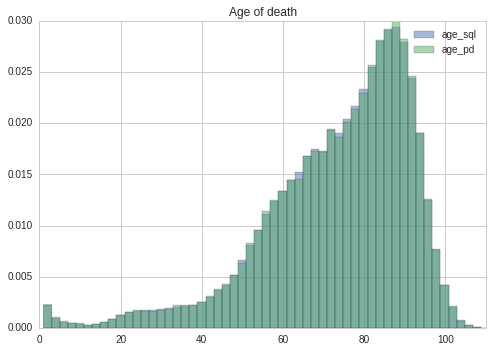

In [135]:
# Dessinons la distribution pour l'échantillon et la population générale

#Pandas and SQL
plt.xlim(0, 110)
plt.title("Distribution de l'age de décés")
# SQL
age_sql = sql_query("SELECT Age FROM causesofdeath")
age_sql = age = pd.Series([x[0] for x in age_sql])
plt.hist(age_sql, 500, alpha=0.5, label='age_sql',normed = 1)

# Pandas
plt.hist(df.Age, 500, alpha=0.5, label='age_pd', normed = 1)

plt.legend(loc='upper right')
plt.show()



In [136]:
#Estimons l'age moyen de décés par sexe

print("Pandas: ",df.groupby('Sex')['Age'].mean())
print("SQL: ",{l[0]:l[1] for l in sql_query("SELECT Sex,AVG(Age) FROM causesofdeath GROUP BY Sex;")})

Pandas:  Sex
F    76.766790
M    70.211249
Name: Age, dtype: float64
SQL:  {'F': 76.67668479891668, 'M': 70.22785796955374}


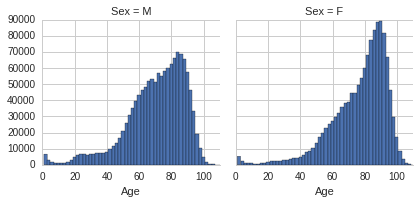

In [146]:
# Afficher la distribution de l'age moyen par sexe'
age_sex = sql_query("SELECT Age,Sex FROM causesofdeath")
age_sex = pd.DataFrame([{k:l for k,l in zip(['Age','Sex'],row)} for row in age_sex])
g = sns.FacetGrid(age_sex,col='Sex')
g.set(xlim=(0,110))
g.map(plt.hist, "Age",bins = 500)

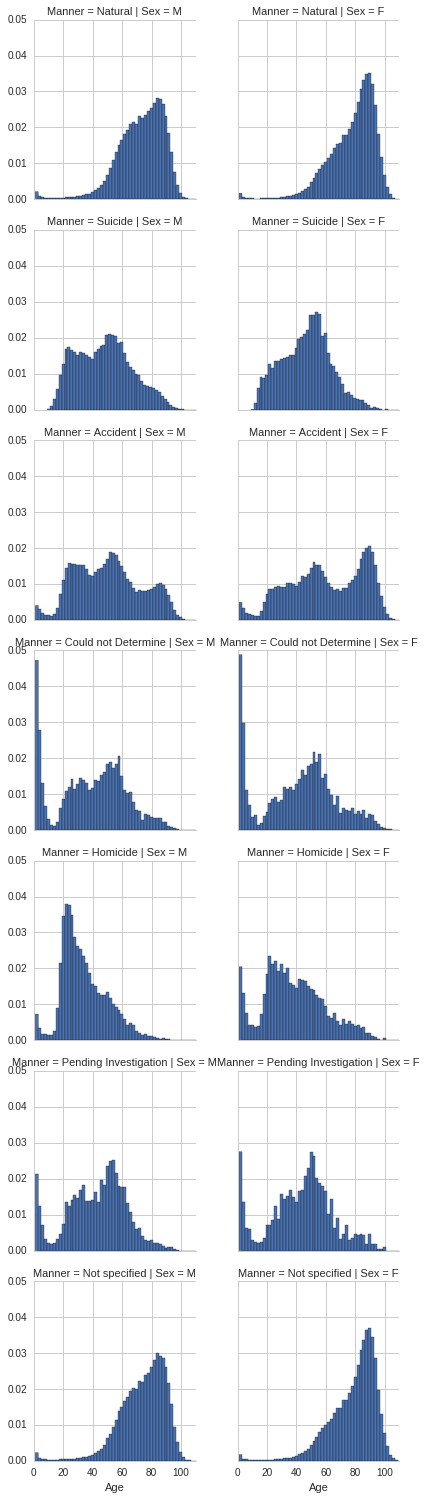

In [175]:
# Afficher les distributions de l'age moyen de deces par sex et cause de deces Mix Python et SQL
# Ajout d'une colonne contenant les labels
"""
#db.cursor().execute("ALTER TABLE causesofdeath ADD COLUMN 'MannerOfDeathLbl' 'char(22)';")
#db.commit()"""

# Mise a jour de la colonne en fonction de la valeur de MannerOfDeath
"""db.cursor().execute(UPDATE `causesofdeath`
SET `MannerOfDeathLbl` = (
  CASE 
    WHEN `MannerOfDeath` = 1 THEN 'Accident'
    WHEN `MannerOfDeath` = 2 THEN 'Suicide'
    WHEN `MannerOfDeath` = 3 THEN 'Homicide'
    WHEN `MannerOfDeath` = 4 THEN 'Pending Investigation'
    WHEN `MannerOfDeath` = 5 THEN 'Could not Determine'
    WHEN `MannerOfDeath` = 6 THEN 'Self-inflicted'
    WHEN `MannerOfDeath` = 7 THEN 'Natural'
    WHEN `MannerOfDeath` = 0 THEN 'Not specified'
  END))
db.commit()"""


age_sex_manner = sql_query("SELECT Age,Sex,MannerOfDeathLbl FROM causesofdeath")
age_sex_manner = pd.DataFrame([{k:l for k,l in zip(['Age','Sex','Manner'],row)} for row in age_sex_manner])
g = sns.FacetGrid(age_sex_manner,col='Sex',row = 'Manner')
g.set(xlim=(0,110))
g.map(plt.hist, "Age",bins = 500,normed = 1)
